In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
(columsn
EPOCHS = 50

df = pd.read_csv('Spotify_Labeled_Dataset_2000.csv')
df = df.drop(columns = ['Unnamed: 0', 'track_id', 'artist_name', 'track_name', 'genre'])
print(df.shape)
df.head()

(2000, 16)


,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Mood
0,0,2000,0.263,0.404,2,-8.402,1,0.0393,0.92600,0.00531,0.215,0.226,82.820,159760,1,Sad
1,12,2010,0.515,0.228,0,-21.447,0,0.0519,0.92500,0.86300,0.114,0.462,124.253,269187,3,Calm
2,13,2015,0.482,0.689,9,-10.530,0,0.0545,0.00656,0.51800,0.136,0.107,130.074,69669,4,Calm
3,3,2008,0.167,0.343,9,-25.948,1,0.0693,0.86000,0.97100,0.083,0.034,125.993,350560,3,Sad
4,11,2017,0.457,0.719,0,-9.791,1,0.0348,0.01790,0.83700,0.105,0.488,174.987,209533,4,Energetic


In [32]:
Y = df['Mood']
X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
X.head()

,energy,valence,acousticness,tempo,loudness
0,0.404,0.226,0.92600,82.820,-8.402
1,0.228,0.462,0.92500,124.253,-21.447
2,0.689,0.107,0.00656,130.074,-10.530
3,0.343,0.034,0.86000,125.993,-25.948
4,0.719,0.488,0.01790,174.987,-9.791


In [36]:
X_MinMax = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X_MinMax, columns=X.columns)

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)

label_mapping = pd.DataFrame({
    'Label': encoder.classes_,
    'Encoded': range(len(encoder.classes_))
})

print(label_mapping)
X.head()

       Label  Encoded
0       Calm        0
1  Energetic        1
2      Happy        2
3        Sad        3


,energy,valence,acousticness,tempo,loudness
0,0.403605,0.231084,0.930653,0.401883,0.741594
1,0.227489,0.472393,0.929648,0.602936,0.444414
2,0.688794,0.109407,0.006593,0.631182,0.693116
3,0.342565,0.034765,0.864322,0.611379,0.341876
4,0.718814,0.498978,0.017990,0.849122,0.709951


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size = 0.2, random_state = 10)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


DR = 0.25
def SequentialModel():
    
    model = Sequential()

    model.add(Dense(32, activation = 'relu', input_shape=(5,)))
    model.add(BatchNormalization())
    model.add(Dropout(DR))

    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(DR))

    model.add(Dense(8, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(DR))

    model.add(Dense(4, activation = 'softmax'))

    model.compile(optimizer = Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=20, min_lr= 0.00001, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=20, restore_best_weights=True, verbose=2)
callbacks_list = [rlrop, early_stop]

model = SequentialModel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                192       
                                                                 
 batch_normalization_9 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_10 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 16)               

In [56]:
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn = SequentialModel, epochs = 50, batch_size = 32, verbose = 0)

KFold_Validation = KFold(n_splits = 5, shuffle = True, random_state = 10)
CV_score = cross_val_score(model, X_train, Y_train, cv = KFold_Validation, scoring = 'accuracy')

print(f'Cross-validation scores: {CV_score}')
print(f'Mean CV accuracy: {CV_score.mean()}')

C:\Users\rafid\AppData\Local\Temp\ipykernel_6356\4024389384.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = SequentialModel, epochs = 50, batch_size = 32, verbose = 0)


10/10 [==============================] - 0s 5ms/step
Cross-validation scores: [0.890625 0.9125   0.9125   0.915625 0.915625]
Mean CV accuracy: 0.909375


In [62]:
model = SequentialModel()

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50
40/40 [==============================] - 1s 17ms/step - loss: 1.4698 - accuracy: 0.3438 - val_loss: 1.2694 - val_accuracy: 0.4594 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 1s 18ms/step - loss: 1.1332 - accuracy: 0.4672 - val_loss: 1.1703 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 1s 13ms/step - loss: 1.0151 - accuracy: 0.5695 - val_loss: 1.0554 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 1s 13ms/step - loss: 0.9193 - accuracy: 0.6313 - val_loss: 0.9488 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 1s 13ms/step - loss: 0.8603 - accuracy: 0.6586 - val_loss: 0.8562 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 1s 14ms/step - loss: 0.8197 - accuracy: 0.6828 - val_loss: 0.7906 - val_accuracy: 0.7719 - lr: 0.0010
Epoch 7/50
40/40 [==============================] - 1s 13ms/step - loss: 0.7

In [72]:
import numpy as np

best_accuracy_index = np.argmax(history.history['accuracy'])
best_train_accuracy = max(history.history['accuracy'])
best_train_loss = history.history['loss'][best_accuracy_index]
print('Training Loss, Training Accuracy: ', best_train_loss, best_train_accuracy)

Training Loss, Training Accuracy:  0.41734442114830017 0.858593761920929


In [63]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss, Test Accuracy: ', test_loss, test_accuracy)

Test Loss, Test Accuracy:  0.21127931773662567 0.9225000143051147


In [73]:
validation_loss, validation_accuracy = model.evaluate(X_train, Y_train, verbose=0)  
print('Validation Loss, Validation Accuracy: ', validation_loss, validation_accuracy)

Validation Loss, Validation Accuracy:  0.21145087480545044 0.9168750047683716


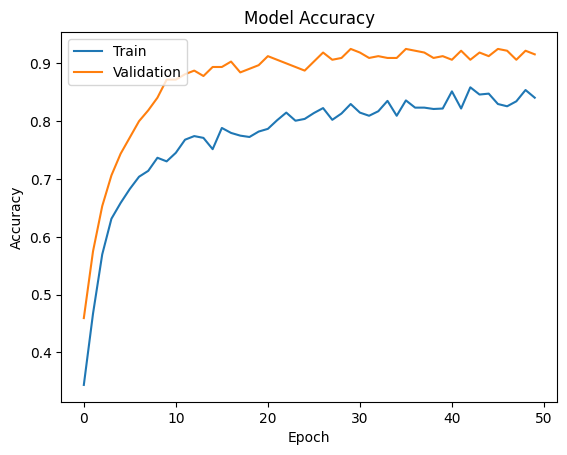

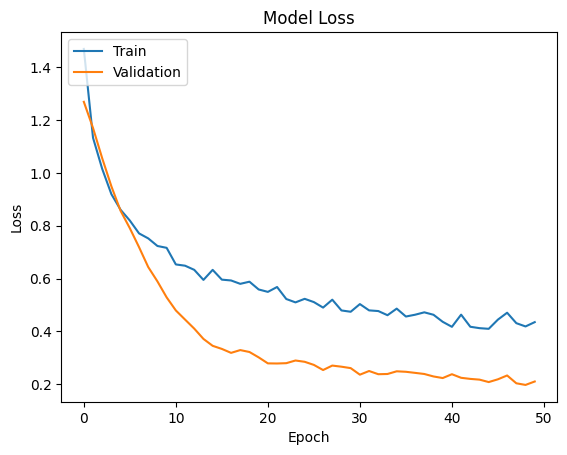

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % test_accuracy
model.save('C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Mood Inference from Music/Saved Models/' + 'NeuralNetwork' + epoch_str + test_acc + '.h5')